In [1]:
from torchvision import transforms
from torch.utils import data
import numpy as np
import argparse
import torch
print(torch.__version__, torch.version.cuda)
from models_mamba_original import vim_tiny_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2
from mamba_lrp.model.vision_mamba import ModifiedVisionMamba
from huggingface_hub import hf_hub_download

2.9.0+cu128 12.8


/home/matteo/miniforge3/envs/mambaLRPTEST/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/matteo/miniforge3/envs/mambaLRPTEST/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/matteo/miniforge3/envs/mambaLRPTEST/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/matteo/miniforge3/envs/mambaLRPTEST/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: 

## Dataset Loading

In [2]:
DATASET_ROOT = './CUB/DATASET/CUB_200_2011'
DATASET_VALIDATION_RANDOM_SEED = 123
BATCH_SIZE = 1
DATASET_WORK_NUMBER = 8
DATASET_SPLIT_RATIO = 0.9

In [3]:
from DatasetLoader.cub import CUB

trans_train = transforms.Compose([
    # A SCELTA NOSTRA AUGUMENTATION
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(30),
    
    # ATTENZIONE QUA NON DOVREBBE SERIVIRE IL RESIZE (?)
    # transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trans_test = transforms.Compose([
    # ATTENZIONE QUA NON DOVREBBE SERIVIRE IL RESIZE (?)
    transforms.Resize((224, 224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# create dataset
train_data = CUB(DATASET_ROOT, 'train', DATASET_SPLIT_RATIO, DATASET_VALIDATION_RANDOM_SEED, transform=trans_train)
valid_data = CUB(DATASET_ROOT, 'valid', DATASET_SPLIT_RATIO, DATASET_VALIDATION_RANDOM_SEED, transform=trans_test)
test_data = CUB(DATASET_ROOT, 'test', 0, 0, transform=trans_test)

print("Train: {}".format(len(train_data)))
print("Valid: {}".format(len(valid_data)))
print("Test: {}".format(len(test_data)))

Train: 5395
Valid: 599
Test: 5794


In [4]:
from matplotlib import pyplot as plt

def imshow(image, label, ax=None, normalize=True):
    """show single along with label on an ax"""
    
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(label)

    return ax


def show_samples(images, labels, nrows=2, ncols=3, title=None, normalize=True):
    """ show multiple samples

    args:
        nrows (int, optional): number of row
        ncols (int, optional): number of column
        title (str, optional): title.
        normalize (bool, optional): whether the images are normalized
    """
    fig, axes = plt.subplots(nrows, ncols, facecolor='#ffffff', dpi=100)

    # .flat: to map samples to multi-dimensional axes
    for (ax, image, label) in zip(axes.flat, images, labels):
        ax = imshow(image, label, ax, normalize)

    fig.suptitle(title)
    fig.tight_layout = True
    fig.subplots_adjust(top=0.85, hspace=0.3)
    plt.show()
    

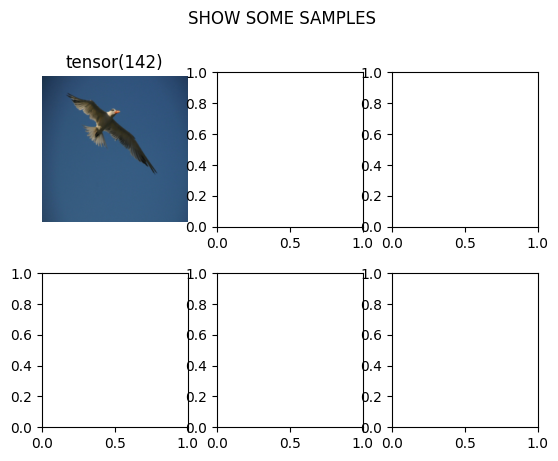

In [5]:
# show samples
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
images, labels, _ = next(iter(train_loader))
show_samples(images[0:6], labels[0:6], 2, 3, 'SHOW SOME SAMPLES')

In [6]:
# create dataloader
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=DATASET_WORK_NUMBER)
valid_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=DATASET_WORK_NUMBER)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=DATASET_WORK_NUMBER)

# Model creation (work in progress)

#### parameters that were removed from previous versions of Mamba-ssm (and default values):
- bimamba_type (='v2' in VisionMamba, =False in Mamba-ssm)
- if_divide_out (=False)
- init_layer_scale (=None)

In [7]:
from huggingface_hub import list_repo_files
from einops import repeat
files = list_repo_files("hustvl/Vim-tiny-midclstok")
print(files)

['.gitattributes', 'README.md', 'vim_t_midclstok_76p1acc.pth', 'vim_t_midclstok_ft_78p3acc.pth']


In [8]:
model = vim_tiny_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2(pretrained=False)

In [9]:

checkpoint_path = hf_hub_download(repo_id="hustvl/Vim-tiny-midclstok", filename="vim_t_midclstok_76p1acc.pth")

torch.serialization.add_safe_globals([argparse.Namespace])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
# Load the model's weights

checkpoint = torch.load(checkpoint_path)
status = model.load_state_dict(checkpoint['model'], strict=False)

#assert len(status.missing_keys) == 0


print(device)
model.to(device)
model.eval()


modified_model = ModifiedVisionMamba(model, zero_bias=True)
modified_model.eval()

cuda


ModifiedVisionMamba(
  (patch_embed): ModifiedPatchEmbed(
    (proj): ModifiedConv(
      (conv): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (head): ModifiedLinear(
    (fc): Linear(in_features=192, out_features=1000, bias=True)
  )
  (drop_path): DropPath(drop_prob=0.100)
  (layers): ModuleList(
    (0-1): 2 x ModifiedBlock(
      (mixer): ModifiedMamba(
        (in_proj): ModifiedLinear(
          (fc): Linear(in_features=192, out_features=768, bias=False)
        )
        (conv1d): ModifiedConv(
          (conv): Conv1d(384, 384, kernel_size=(4,), stride=(1,), padding=(3,), groups=384)
        )
        (act): ModifiedAct(
          (modified_act): Identity()
          (act): SiLU()
        )
        (softplus): ModifiedSoftPlus(
          (modified_act): Identity()
          (act): Softplus(beta=1.0, threshold=20.0)
        )
        (x_proj): ModifiedLinear(
          (fc): Linear(in_feature

In [10]:
from captum.attr import visualization as viz
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [15]:
from mamba_lrp.lrp.utils import vision_relevance_propagation

In [ ]:
from PIL import Image
from scipy.spatial.distance import jensenshannon
from scipy.spatial import distance
from scipy.stats import pearsonr
import torchvision.transforms.functional as TF
import os
import warnings


ModuleNotFoundError: No module named 'scipy'

In [ ]:
# Function to calculate distributions from heatmaps (with resize if necessary)
def saliency_to_distribution(saliency_map, target_size=None, eps=1e-12):
  
    # Convert to np.array
    if isinstance(saliency_map, Image.Image):
        # PIL image
        array = np.array(saliency_map, dtype=np.float64)
    elif isinstance(saliency_map, torch.Tensor):
        # PyTorch tensor
        array = saliency_map.detach().cpu().numpy().astype(np.float64)
    elif isinstance(saliency_map, np.ndarray):
        array = saliency_map.astype(np.float64)
    else:
        raise TypeError("The input must be a PIL Image, np.ndarray, or torch.Tensor")
    
    # We make sure it's 2D
    array = np.squeeze(array)
    if array.ndim != 2:
        raise ValueError(f"Input map must be 2D or convertible to 2D. Input shape: {saliency_map.shape}")

    # Resize
    if target_size is not None:
        # target_size is (H, W), PIL.resize needs (W, H)
        pil_target_size = (target_size[1], target_size[0]) 
        if array.shape != target_size:
            # Conversion to PIL image for a more consistent resize
            pil_img = Image.fromarray(array)
            # Bilinear interpolation 
            pil_img = pil_img.resize(pil_target_size, Image.BILINEAR) 
            array = np.array(pil_img, dtype=np.float64)
    
    # Computing distribution
    # No negative values
    array = np.clip(array, a_min=0, a_max=None)
    
    dist = (array + eps).ravel()
    
    # Normalization
    dist_sum = dist.sum()
    if dist_sum < 1e-9: 
        warnings.warn("Saliency map near 0. Returning a uniform distribution.")
        dist = np.ones_like(dist) / len(dist) 
    else:
        dist = dist / dist_sum
            
    return dist

In [ ]:
# GazeMap path
GAZE_MAP_DIR = 'CUB/GAZE_DATASET/CUB_GHA'

# Scores lists
all_jss_scores = []
all_chi2_scores = []
all_pcc_scores = []

print("Computing similarities metrics:")

    
with torch.enable_grad():
    
    for images, labels, image_ids in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        # Obtaining heatmap
        embeddings = model.patch_embed(images)
        #embeddings.requires_grad = False
        R, prediction, logits = vision_relevance_propagation(
            model = modified_model,
            embeddings = embeddings,
            targets = labels,
            n_classes = 1000
        )
        
        try:
            num_patches_side = int(np.sqrt(R.shape[1]))
            print(R.shape)
            model_heatmaps_batch = R[:,:-1].reshape(-1, num_patches_side, num_patches_side)
        except Exception as e:
            print(f"Skipping batch. Error: {e}")
            continue

        # Loop over all the batch images
        for i in range(images.shape[0]):
            
            current_image_id = image_ids[i].item() 
            
            model_map_tensor = model_heatmaps_batch[i]
            
            # Loading the "Ground Truth"
            gaze_map_path = os.path.join(GAZE_MAP_DIR, f"{current_image_id}.jpg")
            
            if not os.path.exists(gaze_map_path):
                warnings.warn(f"Gaze Map File not found, skipping: {gaze_map_path}")
                continue
                
            try:
                gt_img = Image.open(gaze_map_path).convert("L")
                gt_target_size = (gt_img.height, gt_img.width) 
                
                # Computing P and Q
                Q = saliency_to_distribution(gt_img, target_size=None) 
                P = saliency_to_distribution(model_map_tensor, target_size=gt_target_size)
                
                # Computing the metrics
                jsd = jensenshannon(P, Q)
                all_jss_scores.append(1 - jsd)
                all_chi2_scores.append(distance.chisquare(P, Q))
                all_pcc_scores.append(pearsonr(P, Q)[0]) # Only the coefficient
                
            except Exception as e:
                print(f"Error in image {current_image_id}: {e}")

Computing similarities metrics:
(2, 197)
Error in image 1: module 'scipy.spatial.distance' has no attribute 'chisquare'
Error in image 3: module 'scipy.spatial.distance' has no attribute 'chisquare'
(2, 197)
Error in image 6: module 'scipy.spatial.distance' has no attribute 'chisquare'
Error in image 10: module 'scipy.spatial.distance' has no attribute 'chisquare'
(2, 197)
Error in image 12: module 'scipy.spatial.distance' has no attribute 'chisquare'
Error in image 13: module 'scipy.spatial.distance' has no attribute 'chisquare'
(2, 197)
Error in image 14: module 'scipy.spatial.distance' has no attribute 'chisquare'
Error in image 16: module 'scipy.spatial.distance' has no attribute 'chisquare'
(2, 197)
Error in image 17: module 'scipy.spatial.distance' has no attribute 'chisquare'
Error in image 19: module 'scipy.spatial.distance' has no attribute 'chisquare'


KeyboardInterrupt: 

In [ ]:
# Average scores
if all_jss_scores:
    print("\n--- Average Final Results ---")
    print(f"Total processed images: {len(all_jss_scores)}")
    print(f"Jensen-Shannon Similarity (JSS): {np.mean(all_jss_scores):.4f} +- {np.std(all_jss_scores):.4f}")
    print(f"Chi-square Distance (Chi2):     {np.mean(all_chi2_scores):.4f} +- {np.std(all_chi2_scores):.4f}")
    print(f"Pearson Corr. Coeff. (PCC): {np.mean(all_pcc_scores):.4f} +- {np.std(all_pcc_scores):.4f}")
else:
    print("Error.")

In [17]:

images, labels, _ = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

# get patch embeddings (Tensor), shape: (B, num_patches, embed_dim)
embeddings = modified_model.patch_embed(images)
embeddings = model.patch_embed(images)

R, prediction, logits = vision_relevance_propagation(
    model = modified_model,
    embeddings = embeddings,
    targets = labels,
    n_classes = 1000
)


In [18]:
attributions = R[0, 1:]  # Shape: [196]
num_patches = attributions.shape[0]
grid_size = int(np.sqrt(num_patches))


if grid_size * grid_size != num_patches:
    raise ValueError(f"Il numero di patch ({num_patches}) non è un quadrato perfetto!")

heatmap = attributions.reshape(grid_size, grid_size) # Shape: [14, 14]

heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

heatmap_tensor = torch.tensor(heatmap).detach().cpu()

original_image = images[1].detach().cpu()

image_to_show = original_image.permute(1, 2, 0).numpy()

heatmap_tensor = heatmap_tensor.unsqueeze(0).unsqueeze(0) # Shape: [1, 1, 14, 14]

upscaled_heatmap = F.interpolate(
    heatmap_tensor,
    size=image_to_show.shape[:2], # Prende Altezza e Larghezza (es. [224, 224])
    mode='bilinear',
    align_corners=False
)

heatmap_to_show = upscaled_heatmap.squeeze().numpy() # Shape: [224, 224]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


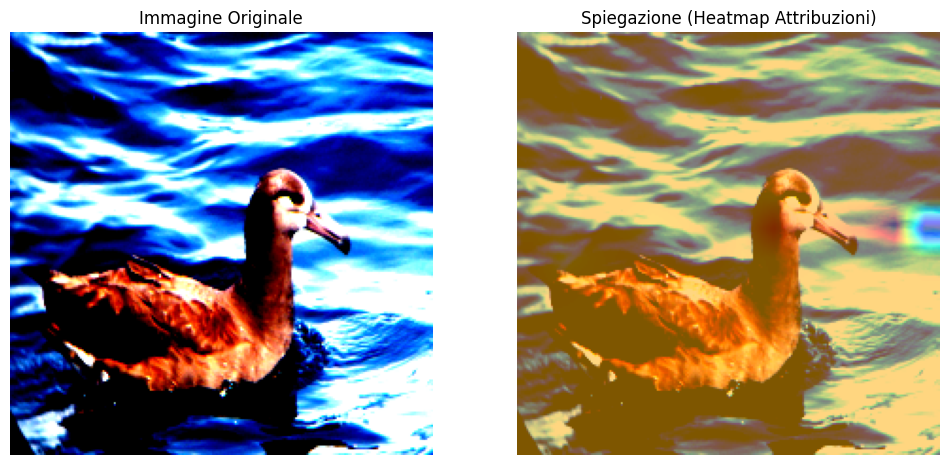

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image_to_show)
ax1.set_title("Immagine Originale")
ax1.axis('off')
ax2.imshow(image_to_show)
ax2.imshow(
    heatmap_to_show,
    cmap='jet', # 'jet' o 'viridis' sono buone scelte
    alpha=0.5    # Trasparenza per vedere l'immagine sotto
)
ax2.set_title("Spiegazione (Heatmap Attribuzioni)")
ax2.axis('off')

plt.show()
